# Analysis of kinetic properties: Mean First Passage Time (MFPT) and Committors

 In this jupyter notebook the M-WEM results will be analyzed to compute the mean first passage time (MFPT) of transtion between the two states in Alanine dipeptide and also to compute the committor along the milestoning coordinate $\Phi$. This notebook is to be run first (before doing free energy analysis) as the files needed for free energy landscape calculation will be produced by this notebook. 

### Import modules for analysis ###

In [1]:
import numpy as np
import pickle
import scipy.stats as st
import mwem
import matplotlib.pyplot as plt
import scipy.stats as st

## Analysis ##

The below cell is most important in the analysis of M-WEM trajectories. Here we analyze all the ```crossings.pkl``` (and other crossings files) and ```weights.txt``` file (and other weights files) generated from the west.h5 files. This cell, when correctly executed, will produce the following:

1. A file named ```MFPT_convergence_no_err.dat``` containing the value of MFPT as function of iteration
2. A cell probability file for each iteration in the ```cell_probability``` directory. These files are named as follows: ```cell_prob_10.dat``` contains the equilibrium probability distribution in each cell after iteration 10. The first column is the centers of each cell and the second column is the normalized probabilities.  
3. A set of ```N_i_j_x.dat``` files (x = iteration) in the ```N_i_j_files``` directory: These files contain the $N_{ij}$ matrix elements and can be used to check whether certain milestone-to-milestone transitions are undersampled. 
4. A set of ```R_i_x.dat``` files (x = iteration) in the ```R_i_files``` directory: These files contain the $R_{i}$ vector elements.

The $N_{ij}$ and $R_{i}$ matrix elements are used to compute the rate matrix $Q_{ij}$ (Ref. 1) from which kinetics is computed. The $N_{ij}$ matrix elements are used to calculate committor so they are printed seperately. But one can also check the $N_{ij}$ matrix elements to get a qualitative idea of the quality of sampling. If the sampling is poor around milesone $i$, the $N_{i,i-1}$ and $N_{i,i+1}$ elements can be different from each other by several orders of magnitude.

If commitor calculation is not necessary, one can set ```returnNR=False``` in ```mwem.milestoning``` function. Then $N_{ij}$ and $R_{i}$ matrix elements will not be returned.

In [2]:
milestones = [-80.0, -60.0, -40.0, -20.0, 0.0, 20.0, 40.0, 60.0, 80.0]

indices = [0,1,2,3,4,5,6,7]


num_iter_list = [ 2, 4, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
f1 = open('MFPT_convergence_no_err.dat','w')


for num_iter in num_iter_list:
    if num_iter == 100:
        crossings_file = 'crossings.pkl'
        weights_file = 'weights.txt'
    else :
        crossings_file = 'crossings_%d.pkl'%num_iter
        weights_file = 'weights_%d.txt'%num_iter

    MFPT, k_rev, N_i_j, R_i = mwem.milestoning(crossings_file=crossings_file, weights_file=weights_file, indices=indices, milestones=milestones,
        cutoff=1E-8, dt=10*1E-3, start_milestone = 1, end_milestone = len(milestones)-2, radial=False,
        cell_prob_file='cell_probability/cell_prob_%d.dat'%num_iter, returnNR=True)


    print(num_iter,MFPT,file=f1)

    

    np.savetxt('N_i_j_files/N_i_j_%d.dat'%num_iter,N_i_j,fmt='%0.2e')
    np.savetxt('R_i_files/R_i_%d.dat'%num_iter,R_i,fmt='%0.2e')

    print("Iterartion ",num_iter," done")

f1.close()


Iterartion  2  done
Iterartion  4  done
Iterartion  6  done
Iterartion  8  done
Iterartion  10  done
Iterartion  20  done
Iterartion  30  done
Iterartion  40  done
Iterartion  50  done
Iterartion  60  done
Iterartion  70  done
Iterartion  80  done
Iterartion  90  done
Iterartion  100  done


### Plotting of the MFPT ###

The following cell makes a plot of the convergence of the MFPT result as function of number of iterations. The MFPT obtained from long unbiased MD simulation is $1583\pm188$ ps (Ref. 1), which is also shown in the plot.

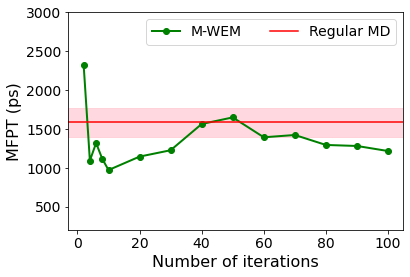

In [3]:
mfpt_data = np.loadtxt('MFPT_convergence_no_err.dat')

plt.plot(mfpt_data[:,0], mfpt_data[:,1], c='g', ls='-', marker='o', lw=2, label='M-WEM' )

plt.xlabel('Number of iterations',fontsize=16)
plt.ylabel('MFPT (ps)',fontsize=16)
plt.ylim(200,3000)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)


plt.axhline(y=1583,color='r',label='Regular MD')
plt.axhspan(1583-188,1583+188,color='pink',alpha=0.6)
plt.legend(fontsize=14,ncol=2)
plt.show()


### Error analysis of MFPT (95% confidence interval) ###

In [4]:
l = np.loadtxt('MFPT_convergence_no_err.dat')

#compute mean and error at 100 iteration by averaging over 
#iteration 60-100

MFPT_list = l[-5:,1]
mean = np.mean(MFPT_list)
conf = st.t.interval(alpha=0.95, df=len(MFPT_list)-1, loc=np.mean(MFPT_list), scale=st.sem(MFPT_list))


print("Mean MFPT +/- error (95% confidence interval)")
print(mean, '+/-', mean-conf[0], 'ps' )


Mean MFPT +/- error (95% confidence interval)
1319.6836337757788 +/- 105.39413666926316 ps


### Committor calculation ###

The committor values at the milestone interfaces (i.e. along the milestoning reaction coordinate) is calculated in the next cell. First, the transition matrix ($\mathbf{K}$) is constructed from $N_{ij}$ matrix elements. Then the committor vector ($\mathbf{C}$) is computed from $\mathbf{K}$. 

In [5]:
iters = [60, 70, 80, 90, 100]

for num_iter in iters:
    N_i_j = np.loadtxt('N_i_j_files/N_i_j_%d.dat'%num_iter)
    K = mwem.K_matrix(N_i_j)
    #print(K)
    C = mwem.committor(K,tol=1E-4,Niter=100)

    f1 = open('committor/committor_%d.dat'%num_iter,'w')

    for i in range(len(C)):
        print(milestones[i],C[i],file=f1)

    f1.close()

converged at iteration:  20
converged at iteration:  20
converged at iteration:  20
converged at iteration:  20
converged at iteration:  20


### Plotting of Committor values ###

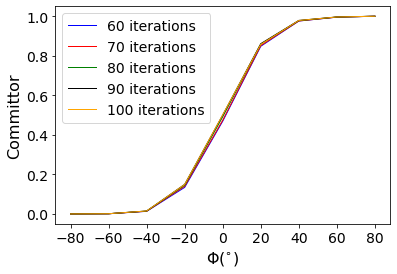

In [6]:
#compute errors of committor profile
committor1 = np.loadtxt('committor/committor_60.dat')
committor2 = np.loadtxt('committor/committor_70.dat')
committor3 = np.loadtxt('committor/committor_80.dat')
committor4 = np.loadtxt('committor/committor_90.dat')
committor5 = np.loadtxt('committor/committor_100.dat')

plt.plot(committor1[:,0], committor1[:,1], 'b', ls='-',lw=1, label='60 iterations' )
plt.plot(committor2[:,0], committor2[:,1], 'r', ls='-',lw=1, label='70 iterations' )
plt.plot(committor3[:,0], committor3[:,1], 'g', ls='-',lw=1, label='80 iterations' )
plt.plot(committor4[:,0], committor4[:,1], 'k', ls='-',lw=1, label='90 iterations' )
plt.plot(committor5[:,0], committor5[:,1], 'orange', ls='-',lw=1, label='100 iterations' )


plt.xlabel('$\Phi (^{\circ})$',fontsize=16)
plt.ylabel('Committor',fontsize=16)
#plt.legend(fontsize=16,ncol=1,loc="upper right")
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.show()

### References ###

1.  "Markovian Weighted Ensemble Milestoning (M-WEM): Long-time Kinetics from Short Trajectories" Dhiman Ray, Sharon E. Stone, Ioan Andricioaei, J. Chem. Theory Comput. 2022, 18, 1, 79–95 https://doi.org/10.1021/acs.jctc.1c00803